In [0]:
! git clone https://github.com/cggcaio/Anomaly-Detection-for-Driver-Identification.git

Cloning into 'Anomaly-Detection-for-Driver-Identification'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 4), reused 26 (delta 2), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gzip
import pandas as pd

In [0]:
  columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
"dst_bytes", "land", "wrong_fragment", "urgent",
    "hot", "num_failed_logins", "logged_in", "num_compromised", 
"root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
"num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
"srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
"dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
"dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

with gzip.open('/content/Anomaly-Detection-for-Driver-Identification/IsolationForest/kddcup.data.gz', 'rb') as f:
    df = pd.read_csv(f, sep=",", names=columns, index_col=None)
    print(df.shape)
    df = df[df["service"] == "http"]
    df = df.drop("service", axis=1)
    columns.remove("service")
    print(df.shape)
    print(df["label"].value_counts())
    


(4898431, 42)
(623091, 41)
normal.       619046
back.           2203
neptune.        1801
portsweep.        16
ipsweep.          13
satan.             7
phf.               4
nmap.              1
Name: label, dtype: int64


In [0]:
for col in df.columns:                         # Transform string data in number, example [ "John", "Bob", "Robert"], when "John" -> 1, "Bob" ->2 ...
  if df[col].dtype =="object":
      encoded = LabelEncoder()
      encoded.fit(df[col])                     # Gives the label encoder all of the data in the column from which it extracts the unique categorical values from
      df[col] = encoded.transform(df[col])

print(df.head(5)) 

for f in range(0, 3):
  df = df.iloc[np.random.permutation(len(df))] # Randomly shuffle all entries to avoid anomalous data blocks.

df2 = df[:500000]                              # Assigning the first 500,000 entries of df to a variable df2.
labels = df2["label"]
df_validate = df[500000:]
x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42) # Scikit-learn function called train_test_split that divide the data between train and test.

x_val, y_val = df_validate, df_validate["label"]

   duration  protocol_type  ...  dst_host_srv_rerror_rate  label
0         0              0  ...                       0.0      4
1         0              0  ...                       0.0      4
2         0              0  ...                       0.0      4
3         0              0  ...                       0.0      4
4         0              0  ...                       0.0      4

[5 rows x 41 columns]


In [0]:
isolation_forest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1, random_state=42)
# n_estimators is the number of trees to use in forest. Default is 100.
# max_samples is the maximum number of data points that the tree should build on. Default is 256 or smaller
# contamination is an estimate of the percentage of the entire data set that should be considered an anomaly. Default is 0.1
# random_state is the number it will initialize the random number generator with to use during the training process.


In [0]:
isolation_forest.fit(x_train) # train isolation forest

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=256, n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

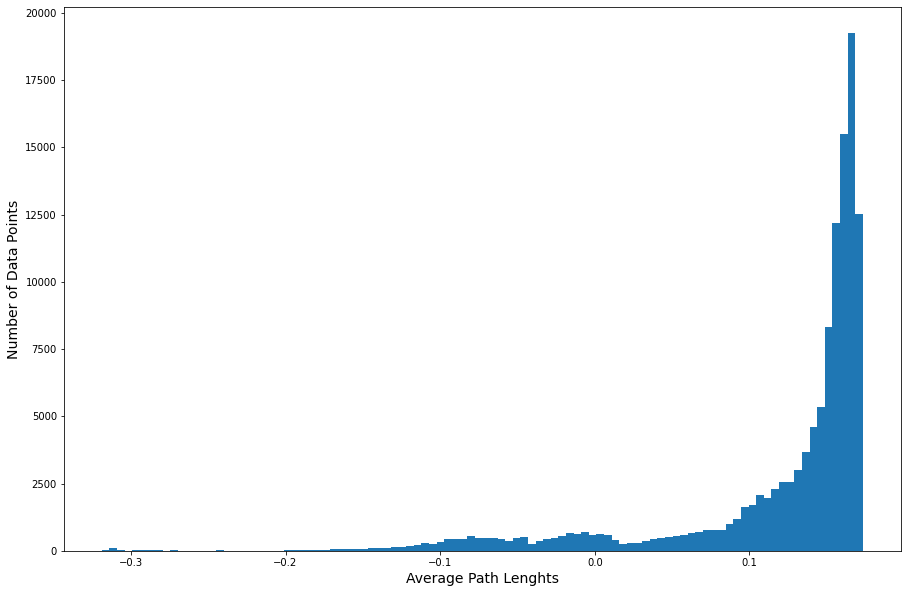

In [0]:
# Hisogram of the anomaly scores tested on the validation set
anomaly_scores = isolation_forest.decision_function(x_val)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores, bins = 100)
plt.xlabel('Average Path Lenghts', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score

anomalies = anomaly_scores > -0.19
matches = y_val == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies, matches)
print("AUC: {:.2%}".format (auc))


AUC: 93.79%


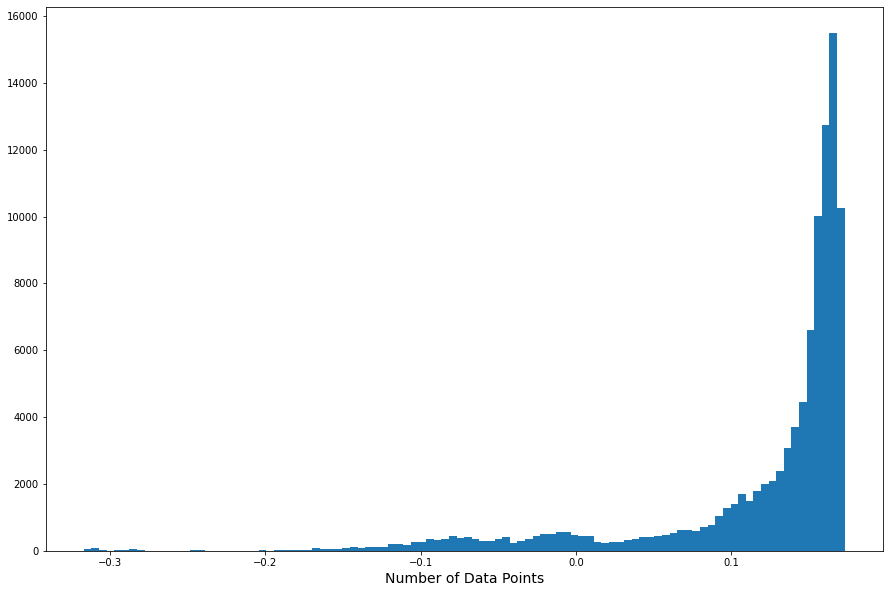

In [0]:
# Hisogram of the anomaly scores tested on the test
anomaly_scores_test = isolation_forest.decision_function(x_test)
plt.figure(figsize=(15,10))
plt.hist(anomaly_scores_test, bins=100)
plt.xlabel("Average Path Lengths", fontsize=14)
plt.xlabel("Number of Data Points", fontsize=14)
plt.show()

In [0]:
anomalies_test = anomaly_scores_test > -0.19
matches = y_test == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies_test, matches)
print("AUC: {:.2%}".format(auc))

AUC: 94.40%
